In [1]:
# correlate Energietisch (2013) and Bundestagswahl (2013)

In [2]:
# module imports
import pandas as pd
import statsmodels.api as sm
import scipy
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from ipynb.fs.full.custom_functions import plot_correlation_matrices, plot_2d_density, plot_residuals

In [3]:
# load Energietisch data into pandas dataframes
energietisch_raw = pd.read_csv("data/Abstimmung_Energietisch_2013.csv")

In [4]:
# clean data
# create unique district ID by concatenating "Bezirksnummer" and "Stimmberzirk"
energietisch_raw["unique_district"] = energietisch_raw["Bezirksnummer"].map(str) + energietisch_raw["Stimmbezirk"].map(str)
# drop all fields but the necessary ones
energietisch_raw["anteil_ja_en"] = energietisch_raw["JA"] / energietisch_raw["gültige_stimmen"]
energietisch_raw["participation_en"] = energietisch_raw["gültige_stimmen"] / energietisch_raw["stimmberechtigte_insgesamt"]
energietisch = energietisch_raw.filter(['unique_district', 'anteil_ja_en', 'participation_en'], axis=1)
print(energietisch)

     unique_district  anteil_ja_en  participation_en
0               1100      0.888889          0.186756
1               1101      0.799076          0.177459
2               1105      0.844769          0.227657
3               1107      0.907895          0.248434
4               1111      0.860231          0.285950
...              ...           ...               ...
1090           12614      0.633907          0.278576
1091           12615      0.676364          0.294748
1092           12616      0.637540          0.308383
1093           12617      0.630178          0.277049
1094           12618      0.787975          0.284941

[1095 rows x 3 columns]


In [5]:
# load Bundeatagswahl 2013 data into pandas dataframe
btw13_raw = pd.read_csv("data/Bundestag_2013.csv")
# create unique district ID by concatenating "Bezirksnummer" and "Stimmberzirk"
btw13_raw["unique_district"] = btw13_raw["Bezirksnummer"].map(str) + btw13_raw["Stimmbezirk"].map(str)
btw13_raw["OstWest_color"] = np.where(btw13_raw["OstWest"] == "O", 'red', 'blue')
btw13_raw["OstWest_binary"] = np.where(btw13_raw["OstWest"] == "O", 0, 1)
# transform percent to value between 0 and 1
btw13_raw["linke_prozent"] = btw13_raw["linke_prozent"] / 100
btw13_raw["grüne_prozent"] = btw13_raw["grüne_prozent"] / 100
btw13_raw["spd_prozent"] = btw13_raw["spd_prozent"] / 100
btw13_raw["cdu_prozent"] = btw13_raw["cdu_prozent"] / 100
btw13_raw["fdp_prozent"] = btw13_raw["fdp_prozent"] / 100
btw13_raw["afd_prozent"] = btw13_raw["afd_prozent"] / 100

# drop all fields but the necessary ones
btw_13 = btw13_raw.filter([
    'unique_district',
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'fdp_prozent',
    'cdu_prozent',
    'afd_prozent',
    'Bezirksnummer',
    'OstWest_color',
    'OstWest_binary',
], axis=1)
print(btw_13)

     unique_district  linke_prozent  grüne_prozent  spd_prozent  fdp_prozent  \
0               1100          0.177          0.162        0.238        0.017   
1               1101          0.182          0.150        0.262        0.058   
2               1102          0.180          0.120        0.274        0.068   
3               1103          0.180          0.197        0.221        0.070   
4               1104          0.132          0.209        0.224        0.079   
...              ...            ...            ...          ...          ...   
1774           12621          0.049          0.141        0.265        0.051   
1775           12622          0.048          0.098        0.262        0.058   
1776           12623          0.049          0.092        0.268        0.058   
1777           12624          0.032          0.102        0.251        0.038   
1778           12625          0.068          0.064        0.345        0.029   

      cdu_prozent  afd_prozent  Bezirks

In [6]:
# Multiple linear regression for  Energietisch (2013) and Bundestagswahl 2013

# also see: # https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/10_multiple_regression.html

btw_13_merged = btw_13.merge(
    energietisch,
    how='inner',
    on='unique_district',
)

Y = btw_13_merged['anteil_ja_en']
X = btw_13_merged[[
    'cdu_prozent',
    'spd_prozent',
    'linke_prozent',
    'grüne_prozent',
    'afd_prozent',
    'fdp_prozent',
    'OstWest_binary',
    'participation_en',
]]
X = sm.add_constant(X)
ks = sm.OLS(Y, X)
ks_res = ks.fit()
ks_res.summary()
print(ks_res.summary())

                            OLS Regression Results                            
Dep. Variable:           anteil_ja_en   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     211.2
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          8.34e-199
Time:                        17:42:40   Log-Likelihood:                 1453.2
No. Observations:                 888   AIC:                            -2888.
Df Residuals:                     879   BIC:                            -2845.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8281      0.076  

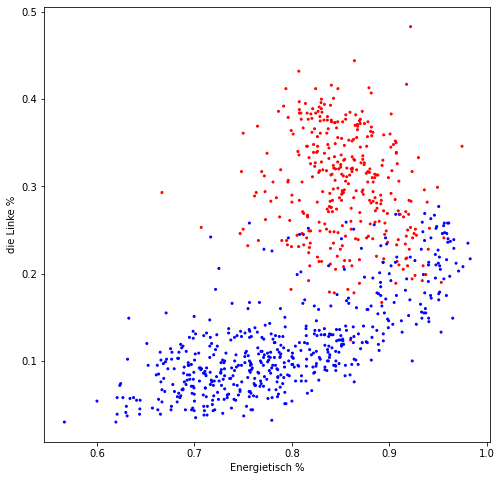

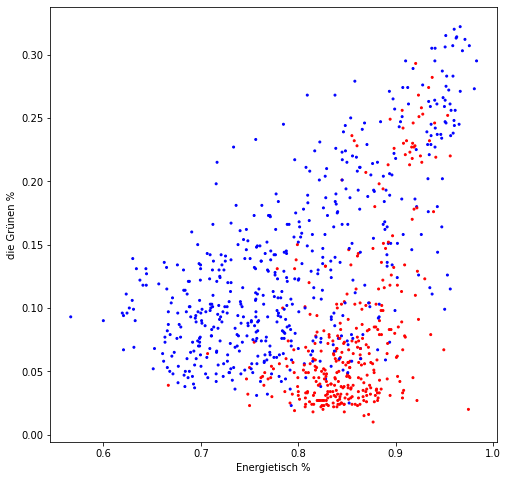

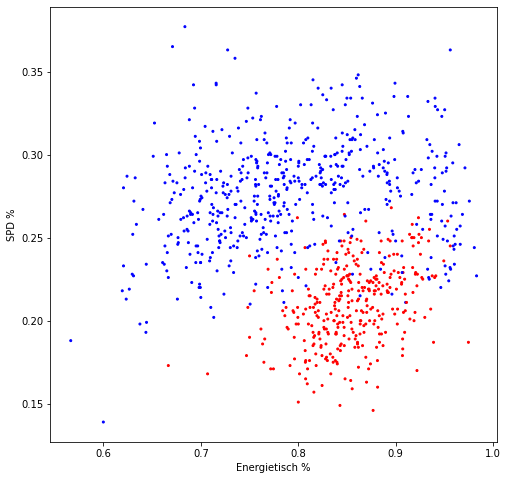

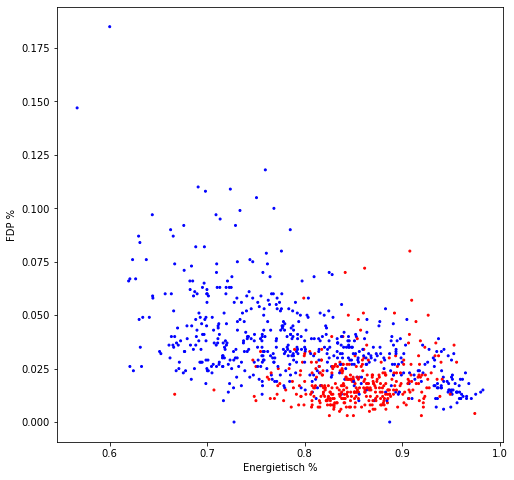

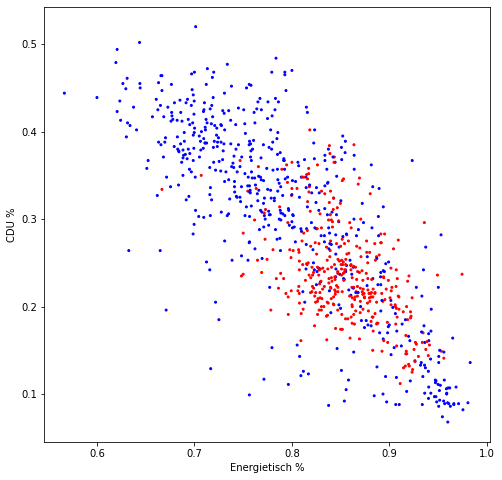

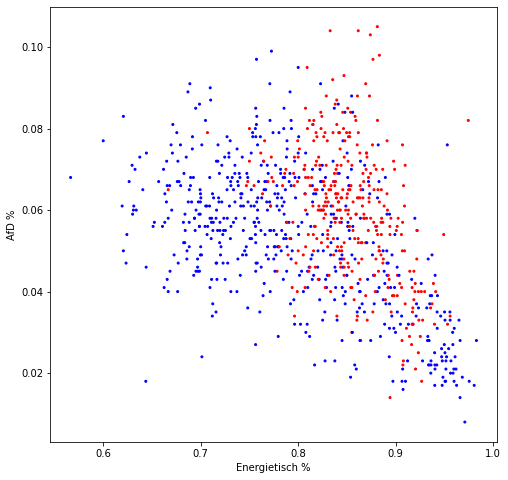

In [7]:
# Scatterplots of all BTW 2013 party results vs. Energietisch individually

party_map = {
    'die Linke %': 'linke_prozent',
    'die Grünen %': 'grüne_prozent',
    'SPD %': 'spd_prozent',
    'FDP %': 'fdp_prozent',
    'CDU %': 'cdu_prozent',
    'AfD %': 'afd_prozent',
}

for party in party_map:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(data=btw_13_merged, x='anteil_ja_en', y=party_map[party], c=btw_13_merged["OstWest_color"], s=4)
    ax.set(title='', xlabel='Energietisch %', ylabel=party)
    plt.show()

   linke_prozent  grüne_prozent  spd_prozent  fdp_prozent  cdu_prozent  \
0          0.177          0.162        0.238        0.017        0.281   
1          0.182          0.150        0.262        0.058        0.256   
2          0.205          0.201        0.245        0.050        0.175   
3          0.214          0.230        0.205        0.080        0.188   
4          0.124          0.228        0.249        0.051        0.247   

   afd_prozent  anteil_ja_en  participation_en  
0        0.042      0.888889          0.186756  
1        0.040      0.799076          0.177459  
2        0.050      0.844769          0.227657  
3        0.023      0.907895          0.248434  
4        0.033      0.860231          0.285950  


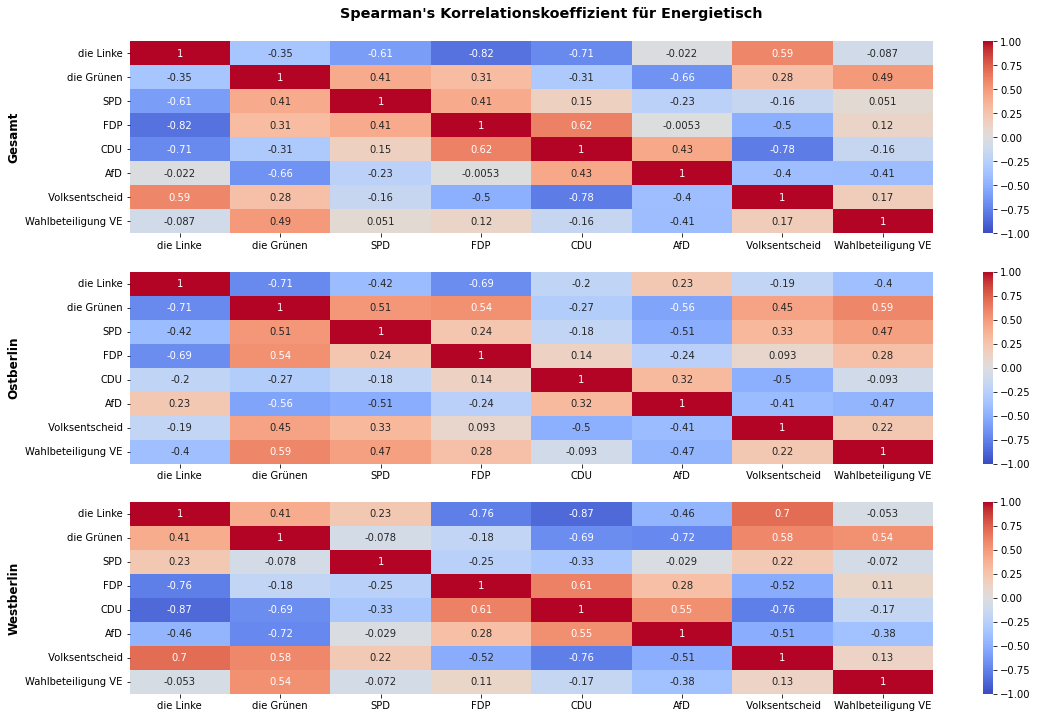

In [8]:
axis_labels = ['die Linke', 'die Grünen', 'SPD', 'FDP', 'CDU', 'AfD', ' Volksentscheid', 'Wahlbeteiligung VE']
plot_correlation_matrices(btw_13_merged, "spearman", "Spearman's", "Energietisch", axis_labels)

   linke_prozent  grüne_prozent  spd_prozent  fdp_prozent  cdu_prozent  \
0          0.177          0.162        0.238        0.017        0.281   
1          0.182          0.150        0.262        0.058        0.256   
2          0.205          0.201        0.245        0.050        0.175   
3          0.214          0.230        0.205        0.080        0.188   
4          0.124          0.228        0.249        0.051        0.247   

   afd_prozent  anteil_ja_en  participation_en  
0        0.042      0.888889          0.186756  
1        0.040      0.799076          0.177459  
2        0.050      0.844769          0.227657  
3        0.023      0.907895          0.248434  
4        0.033      0.860231          0.285950  


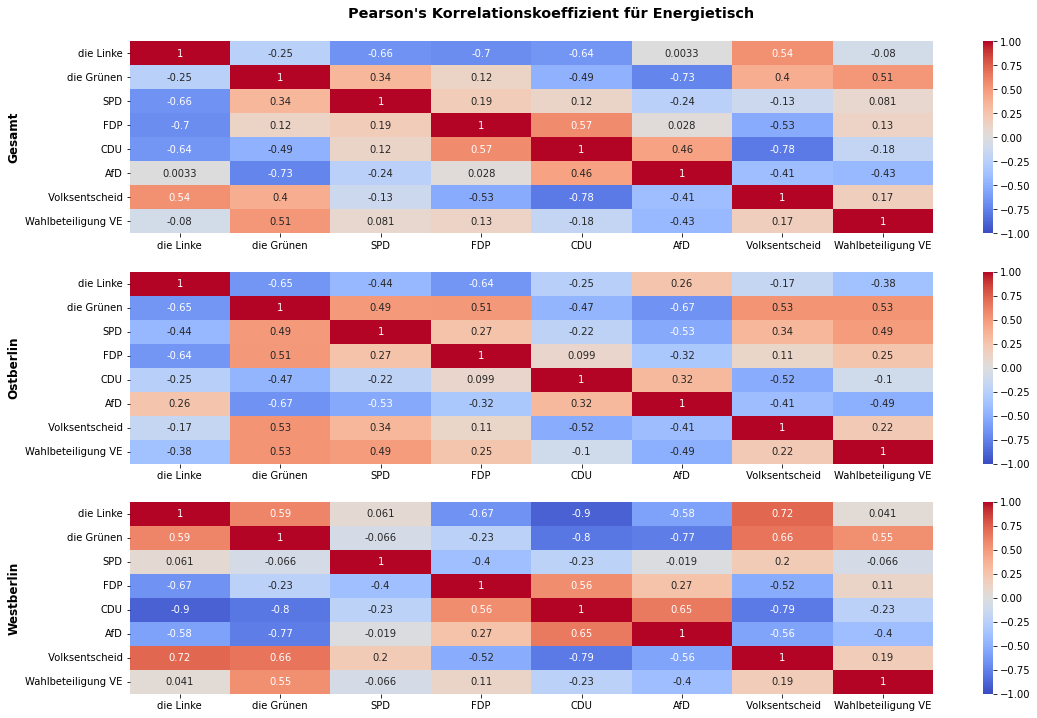

In [9]:
plot_correlation_matrices(btw_13_merged, "pearson", "Pearson's", "Energietisch", axis_labels)

In [10]:
# T-test for significant difference between East and West in Energietisch and party results

energietisch_east = btw_13_merged.loc[btw_13_merged['OstWest_binary'] == 0]
energietisch_east = energietisch_east.filter([
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'cdu_prozent',
    'fdp_prozent',
    'afd_prozent',
    'anteil_ja_en',
    'participation_en',
], axis=1)
energietisch_west = btw_13_merged.loc[btw_13_merged['OstWest_binary'] == 1]
energietisch_west = energietisch_west.filter([
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'cdu_prozent',
    'fdp_prozent',
    'afd_prozent',
    'anteil_ja_en',
    'participation_en',
], axis=1)

p_values = scipy.stats.ttest_ind(a=energietisch_east, b=energietisch_west)[1]
print("p-Werte der T-Tests auf Unterschiede der Grundgesamtheit zwischen Ost- und Westberlin für...")
print("die LINKE: {}".format(p_values[0].round(3)))
print("die Grünen: {}".format(p_values[1].round(3)))
print("SPD: {}".format(p_values[2].round(3)))
print("FDP: {}".format(p_values[3].round(3)))
print("CDU: {}".format(p_values[4].round(3)))
print("AfD: {}".format(p_values[5].round(3)))
print("Zustimmung Energietisch: {}".format(p_values[6].round(3)))
print("Wahlbeteiligung Energietisch: {}".format(p_values[7].round(3)))

p-Werte der T-Tests auf Unterschiede der Grundgesamtheit zwischen Ost- und Westberlin für...
die LINKE: 0.0
die Grünen: 0.0
SPD: 0.0
FDP: 0.0
CDU: 0.0
AfD: 0.0
Zustimmung Energietisch: 0.0
Wahlbeteiligung Energietisch: 0.604


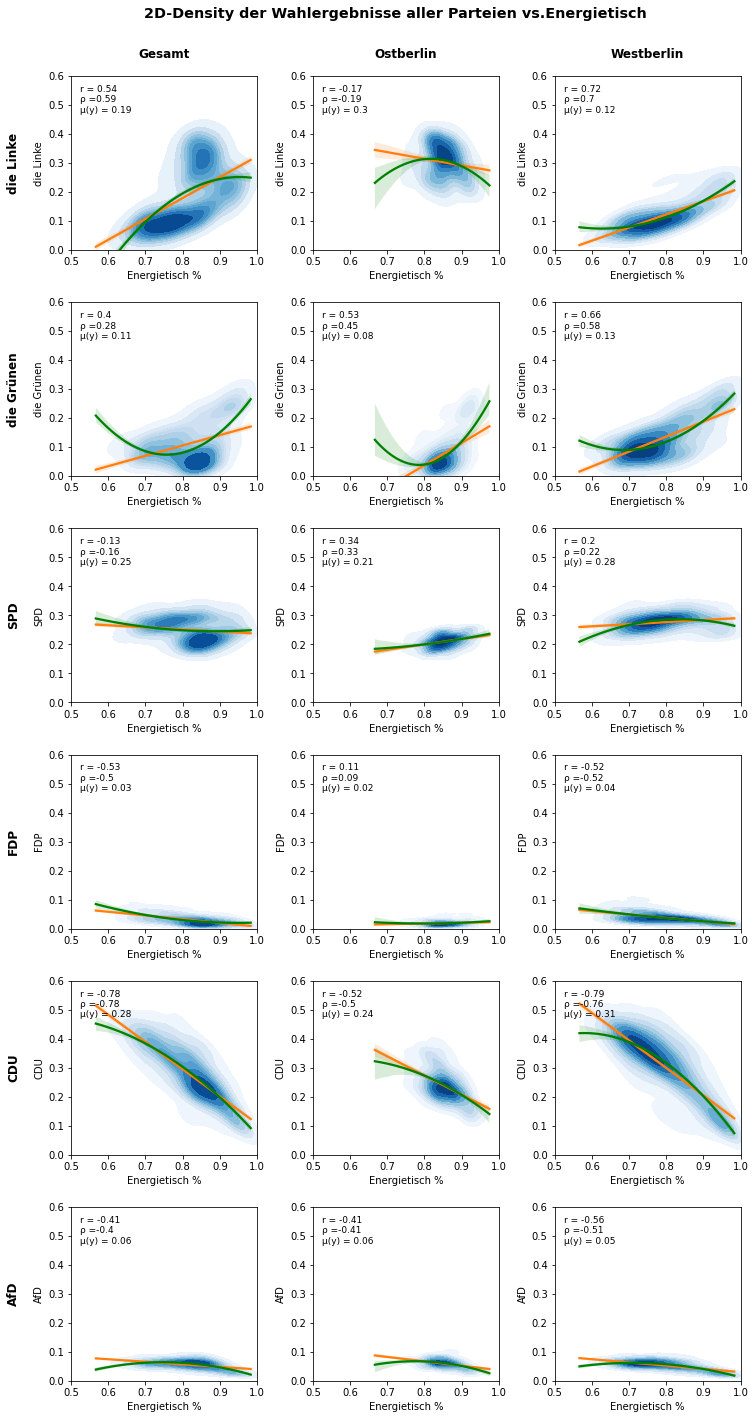

In [11]:
# density plots
dfs = [btw_13_merged, energietisch_east, energietisch_west]
plot_2d_density('Energietisch', dfs,  'anteil_ja_en', 0.5)

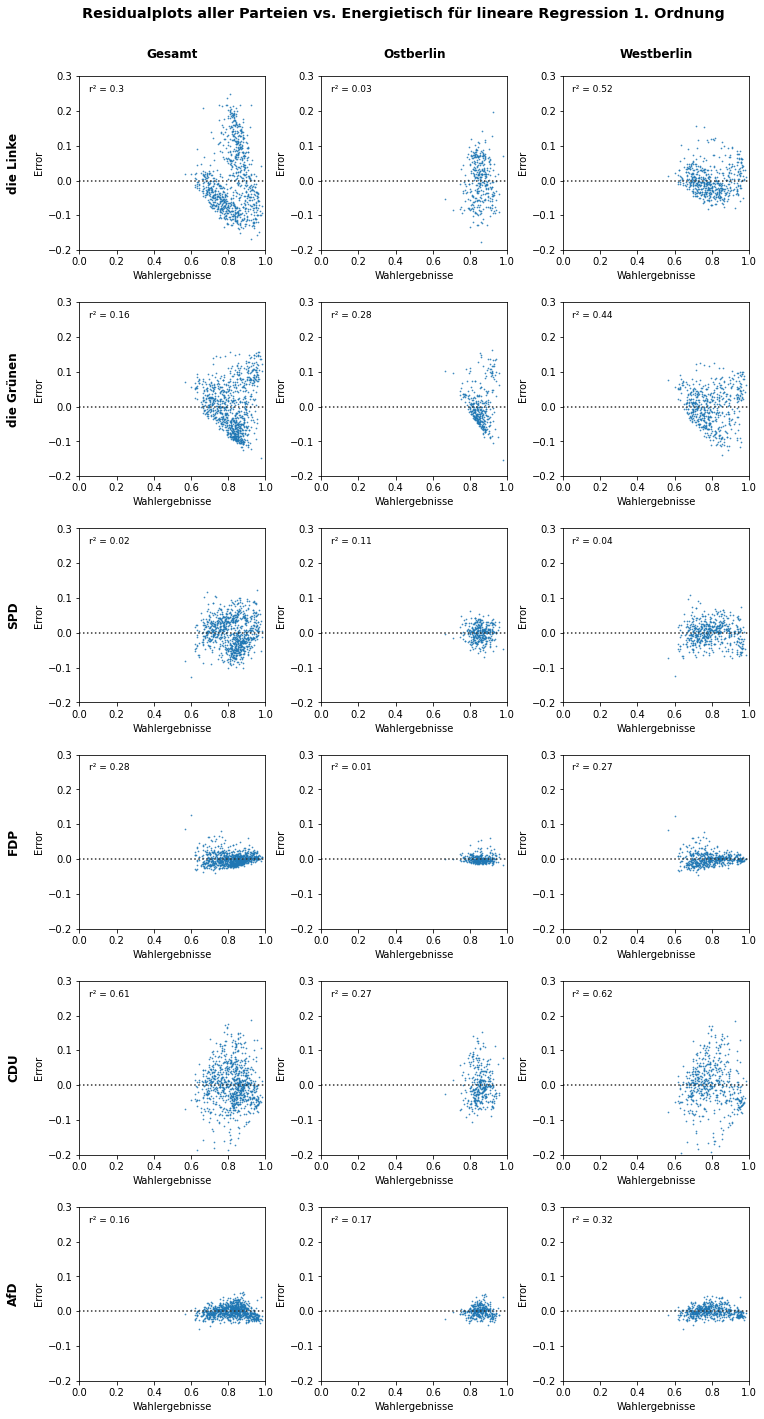

In [12]:
# plot residuals
dfs = [btw_13_merged, energietisch_east, energietisch_west]
plot_residuals(plebiscite_title='Energietisch', dfs=dfs, plebiscite_column_name='anteil_ja_en', pol_order=1)

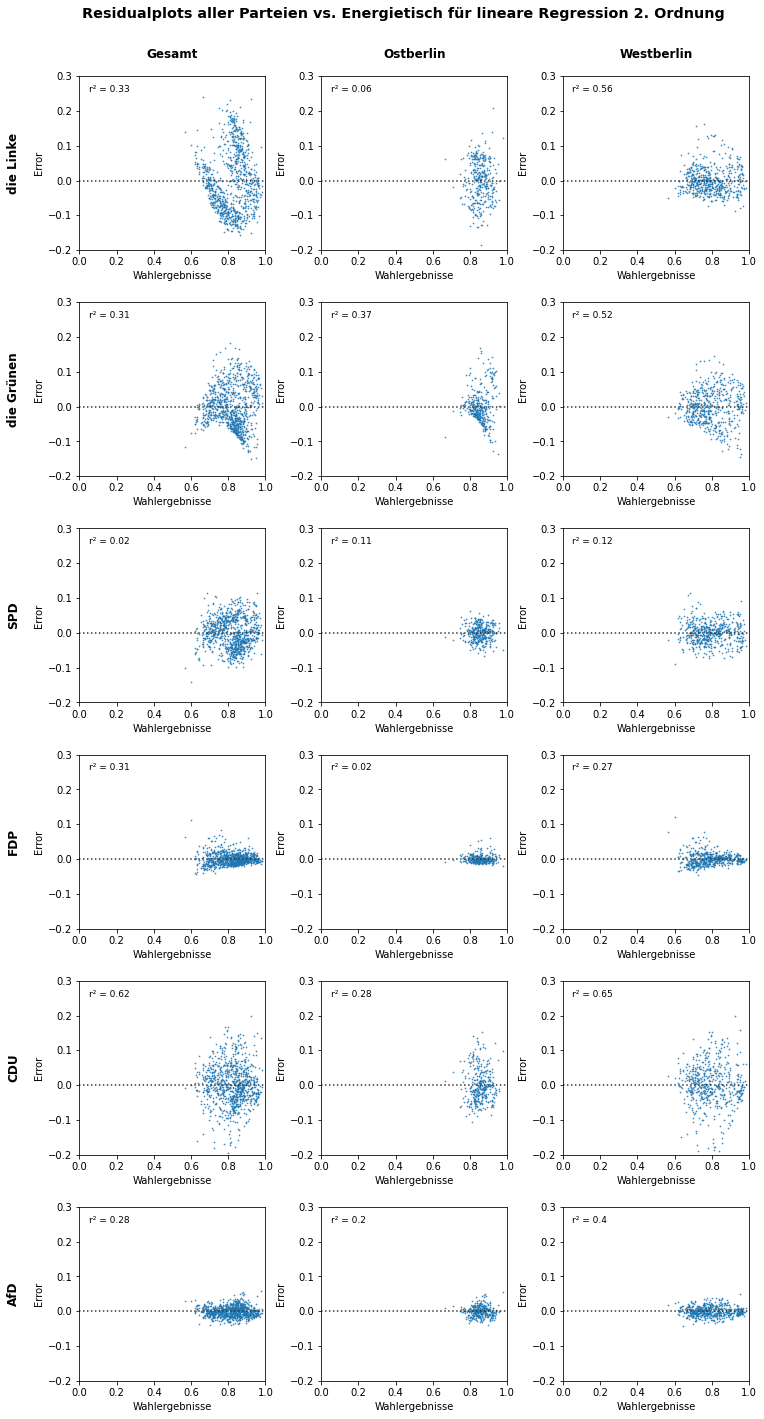

In [13]:
# plot residuals
dfs = [btw_13_merged, energietisch_east, energietisch_west]
plot_residuals(plebiscite_title='Energietisch', dfs=dfs, plebiscite_column_name='anteil_ja_en', pol_order=2)